In [111]:
    !pip install emoji --upgrade
    !pip install pandas-profiling==2.*
    !pip install plotly==4.*
    !python -m spacy download en_core_web_lg
    !pip install pyldavis
    !pip install gensim
    !pip install chart_studio
    !pip install --upgrade autopep8

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [50]:
# Required Libraries

#Base and Cleaning 
import json
import requests
import pandas as pd
import numpy as np
import emoji
import regex
import re
import string
from collections import Counter

#Visualizations
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
import pyLDAvis
import pyLDAvis.sklearn
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls

#Natural Language Processing (NLP)
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel, LdaState
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

In [2]:
def give_emoji_free_text(text):
    """
    Removes emoji's from tweets
    Accepts:
        Text (tweets)
    Returns:
        Text (emoji free tweets)
    """
    emoji_list = [c for c in text if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def url_free_text(text):
    '''
    Cleans text from urls
    '''
    text = re.sub(r'http\S+', '', text)
    return text

# Apply the function above and get tweets free of emoji's
call_emoji_free = lambda x: give_emoji_free_text(x)

In [3]:
df=pd.read_csv('Random Tweets 13000 3_4.csv') 

In [4]:
# Apply `call_emoji_free` which calls the function to remove all emoji's
df['emoji_free_tweets'] = df['Tweet'].apply(call_emoji_free)

#Create a new column with url free tweets
df['url_free_tweets'] = df['emoji_free_tweets'].apply(url_free_text)

In [5]:
nlp = spacy.load('en_core_web_lg')

In [6]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)


# Custom stopwords
custom_stopwords = ['hi','\n','\n\n', '&amp;', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', 
                    '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


tokens = []

for doc in tokenizer.pipe(df['url_free_tweets'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
df['tokens'] = tokens

In [7]:
df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df['tokens']]

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

df['lemmas'] = df['tokens_back_to_text'].apply(get_lemmas)
# Make lemmas a string again
df['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in df['lemmas']]

# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\\w*\\d\\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
df['lemma_tokens'] = df['lemmas_back_to_text'].apply(tokenize)

In [8]:
# Create a id2word dictionary
id2word = Dictionary(df['lemma_tokens'])
print(len(id2word))

32927


In [9]:
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

10872


In [10]:
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in df['lemma_tokens']]

In [11]:
# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=5)
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]
# Create Topics
topics = [' '.join(t[0:10]) for t in words]
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
good people today new book april love way x 😭

------ Topic 1 ------
🤣 year good £ time 😂 ⬛ day people think

------ Topic 2 ------
😂 ️ look ⬜ thank good ❤ yes feel time

------ Topic 3 ------
think people thank need work time look new team go

------ Topic 4 ------
️ know week day right time new people come think



In [ ]:
# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=df['lemma_tokens'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)

In [56]:
df

,Unnamed: 0,Unnamed: 0.1,Tweet,Username,Retweets,Followers,CleanTweet,CleanTweet2,Vader_sent,TextBlob_sent,Different_sent,Topic,emoji_free_tweets,url_free_tweets,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens
0,0,0,@FPL_Banger @Move78_FPL Yeah have for some tim...,fplbooster,0,3314,"yeah, have, for, some, time, now, yet, keep, s...",yeah have for some time now yet keep scouting 😂,Positive,Neutral,1,15,@FPL_Banger @Move78_FPL Yeah have for some tim...,@FPL_Banger @Move78_FPL Yeah have for some tim...,"[@fpl_banger, @move78_fpl, yeah, time, now,, s...","@fpl_banger @move78_fpl yeah time now, scouting 😂","[@fpl_banger, @move78_fpl, yeah, time, scout, 😂]",@fpl_banger @move78_fpl yeah time scout 😂,"[fpl_banger, move78_fpl, yeah, time, scout, 😂]"
1,1,1,@Simonhartmp - we haven’t moved on and just be...,bernardshawlive,0,2287,"-, we, haven, ’, t, moved, on, and, just, beca...",- we haven’t moved on and just because you sa...,Negative,Negative,0,12,@Simonhartmp - we haven’t moved on and just be...,@Simonhartmp - we haven’t moved on and just be...,"[@simonhartmp, haven’t, moved, it,, doesn’t, s...","@simonhartmp haven’t moved it, doesn’t so. nee...","[@simonhartmp, move, need, clear, lot, corrupt...",@simonhartmp move need clear lot corrupt liar ...,"[simonhartmp, move, need, clear, lot, corrupt,..."
2,2,2,@may_achie It's not our country anymore 😔,ChattyMan9,0,1269,"it's, not, our, country, anymore, 😔",it's not our country anymore 😔,Positive,Neutral,1,2,@may_achie It's not our country anymore 😔,@may_achie It's not our country anymore 😔,"[@may_achie, country, anymore, 😔]",@may_achie country anymore 😔,"[@may_achie, country, anymore, 😔]",@may_achie country anymore 😔,"[may_achie, country, anymore, 😔]"
3,3,3,COL'S CRIMINAL LIBRARY: 2 BY MARK SAFRANKO htt...,col2910,0,2234,"col's, criminal, library, :, by, mark, safranko",col's criminal library: by mark safranko,Negative,Negative,0,7,COL'S CRIMINAL LIBRARY: 2 BY MARK SAFRANKO htt...,COL'S CRIMINAL LIBRARY: 2 BY MARK SAFRANKO,"[col's, criminal, library:, 2, mark, safranko]",col's criminal library: 2 mark safranko,"[col, criminal, library, 2, mark, safranko]",col criminal library 2 mark safranko,"[col, criminal, library, 2, mark, safranko]"
4,4,4,"6 months free, next goal is a year https://t.c...",TomLea__,0,208,"months, free, next, goal, is, a, year",months free next goal is a year,Positive,Positive,0,1,"6 months free, next goal is a year https://t.c...","6 months free, next goal is a year","[6, months, free,, goal, year]","6 months free, goal year","[6, month, free, goal, year]",6 month free goal year,"[6, month, free, goal, year]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12985,12985,12985,@coopefnbr @Jeffiwnl @nowaylildavid @Matiqeee ...,TeekewFNBR,0,1351,"init, bit, odd",init bit odd,Negative,Negative,0,8,@coopefnbr @Jeffiwnl @nowaylildavid @Matiqeee ...,@coopefnbr @Jeffiwnl @nowaylildavid @Matiqeee ...,"[@coopefnbr, @jeffiwnl, @nowaylildavid, @matiq...",@coopefnbr @jeffiwnl @nowaylildavid @matiqeee ...,"[@coopefnbr, @jeffiwnl, @nowaylildavid, @matiq...",@coopefnbr @jeffiwnl @nowaylildavid @matiqeee ...,"[coopefnbr, jeffiwnl, nowaylildavid, matiqeee,..."
12986,12986,12986,You’re proving my point that emotional fans li...,NormandeForeman,2,953,"you, ’, re, proving, my, point, that, emotiona...",you’re proving my point that emotional fans li...,Positive,Neutral,1,12,You’re proving my point that emotional fans li...,You’re proving my point that emotional fans li...,"[you’re, proving, point, emotional, fans, can’...",you’re proving point emotional fans can’t dist...,"[prove, point, emotional, fan, distinction, pl...",prove point emotional fan distinction play car...,"[prove, point, emotional, fan, distinction, pl..."
12987,12987,12987,The Head of Deutsche Bank needs to find their ...,SolidarityRnwd,1,1103,"the, head, of, deutsche, bank, needs, to, find...",the head of deutsche bank needs to find their ...,Negative,Positive,1,3,The Head 

In [12]:
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(df['lemmas_back_to_text'])

In [13]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)
GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128, 
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1, 
                                                 learning_decay=0.7, 
                                                 learning_method=None,
                                                 learning_offset=10.0, 
                                                 max_doc_update_iter=100, 
                                                 max_iter=10,
                                                 mean_change_tol=0.001, 
                                                 n_components=10, 
                                                 n_jobs=1,
                                                 perp_tol=0.1, 
                                                 random_state=None,
                                                 topic_word_prior=None, 
                                                 total_samples=1000000.0, 
                                                 verbose=0),
             n_jobs=1,
             param_grid={'n_topics': [10, 15, 20, 30], 
                         'learning_decay': [0.5, 0.7, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
             scoring=None, verbose=0)

GridSearchCV(error_score='raise',
             estimator=LatentDirichletAllocation(learning_method=None,
                                                 n_jobs=1),
             n_jobs=1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_topics': [10, 15, 20, 30]},
             return_train_score='warn')

In [16]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -389145.64494460623
Model Perplexity:  15527.40783672409


In [14]:
#Defining a function to loop over number of topics to be used to find an 
#optimal number of tipics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the 
    LDA model with respective number of topics
    """
    coherence_values_topic = []
    model_list_topic = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list_topic.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_topic.append(coherencemodel.get_coherence())

    return model_list_topic, coherence_values_topic    
# Can take a long time to run.
model_list_topic, coherence_values_topic = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=df['lemma_tokens'],
                                                        start=2, limit=200, step=6) 

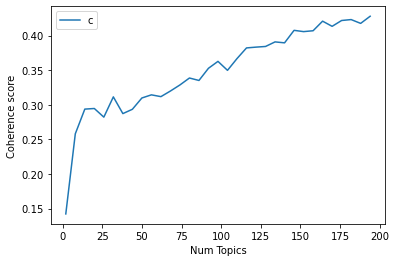

In [15]:
# Show graph
import matplotlib.pyplot as plt
limit=200; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_topic)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [17]:
model_5_2 = LdaMulticore(corpus=corpus,
                       id2word=id2word,
                       num_topics=150,
                       random_state=42,
                       chunksize=2000,
                       passes=25,
                       decay=0.9,
                       iterations=70) 

In [18]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in model_5_2.print_topics(num_topics=150, num_words=20)]
# Create Topics
topics = [' '.join(t[0:10]) for t in words]
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
cool jeremyvineon5 crazy previous april petrol year source criticism tablet

------ Topic 1 ------
game play player boy lbc saturday reply girl jacob_rees_mogg cat

------ Topic 2 ------
kid exclusive potential people think trade delay support properly service

------ Topic 3 ------
debedee21 one battle 🤣 good site iandunt tech people sister

------ Topic 4 ------
😍 😘 thank 2 rise price son wonderful send year

------ Topic 5 ------
yes watch lol second google honestly work court finish suppose

------ Topic 6 ------
card fashion fast worker payment complete 💥 support look job

------ Topic 7 ------
list hard 😆 bear sure coffee work talk chocolate response

------ Topic 8 ------
👍 bloody drink sweet work today kwool kittytm3 tome_c vividutd

------ Topic 9 ------
star lmao super need people new mirror definition active putin

------ Topic 10 ------
🥳 dream april owner eu dave course look progress vacancy

------ Topic 11 ------
s easy scene pm go 90 l business mus

In [136]:
topic_values = model_5_2[corpus]
print(topic_values[6049])
print(max(topic_values[6049], key = lambda i : i[1])[0])

[(25, 0.20063767), (42, 0.20067926), (44, 0.100637175), (103, 0.1006757), (111, 0.3006804)]
111
